In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.HDFStore("train.h5", "r").get("train")

In [3]:
data_clips={'derived_0':8,'derived_1':3.5,'derived_2':10,'derived_3':10,'derived_4':10, 'fundamental_0':1, 'fundamental_1':1.5,
           'fundamental_2':20, 'fundamental_3':1.5, 'fundamental_5':1.5, 'fundamental_6':2,'fundamental_7':2.5,
            'fundamental_8':2, 'fundamental_9':2, 'fundamental_10':6, 'fundamental_11':4, 'fundamental_12':100,
           'fundamental_13':2, 'fundamental_14':2, 'fundamental_15':4, 'fundamental_16':4, 'fundamental_17':10, 
            'fundamental_18':10, 'fundamental_19':6, 'fundamental_20':4, 'fundamental_21':2, 'fundamental_22':1.5,
            'fundamental_23':4,'fundamental_24':2, 'fundamental_25':3, 'fundamental_26':2, 'fundamental_27':4,
           'fundamental_28':1.5, 'fundamental_29':4, 'fundamental_30':4, 'fundamental_31':3, 'fundamental_32':20,
            'fundamental_33':6, 'fundamental_34':150, 'fundamental_35':10, 'fundamental_36':6, 'fundamental_37':4,
           'fundamental_38':4, 'fundamental_39':3, 'fundamental_40':10, 'fundamental_41':12, 'fundamental_42':40,
           'fundamental_43':6, 'fundamental_44':6, 'fundamental_45':6, 'fundamental_46':3, 'fundamental_47':2,
           'fundamental_48':7, 'fundamental_49':3, 'fundamental_50':12, 'fundamental_51':35, 'fundamental_52':4,
           'fundamental_53':3, 'fundamental_54':2.5, 'fundamental_55':5, 'fundamental_56':6, 'fundamental_57':6,
           'fundamental_58':2.5, 'fundamental_59':2, 'fundamental_60':5, 'fundamental_61':12, 'fundamental_62':2,
           'fundamental_63':2, 'technical_0':2, 'technical_1':0.2, 'technical_2':3, 'technical_3':0.3, 'technical_5':0.2,
           'technical_6':3, 'technical_7':1.3, 'technical_9':1, 'technical_10':3, 'technical_11':3, 'technical_12':2,
           'technical_13':0.003, 'technical_14':3, 'technical_16':1, 'technical_17':3, 'technical_18':1,
           'technical_19':4, 'technical_20':0.012, 'technical_21':7, 'technical_22':0.6, 'technical_24':0.4,
           'technical_25':0.15, 'technical_27':5, 'technical_28':0.1, 'technical_29':3, 'technical_30':0.012,
           'technical_31':0.15, 'technical_32':1, 'technical_33':1, 'technical_34':0.6, 'technical_35':4,
           'technical_36':4, 'technical_37':1, 'technical_38':1, 'technical_39':1, 'technical_40':2,
           'technical_41':0.5, 'technical_42':1, 'technical_43':3, 'technical_44':0.1}

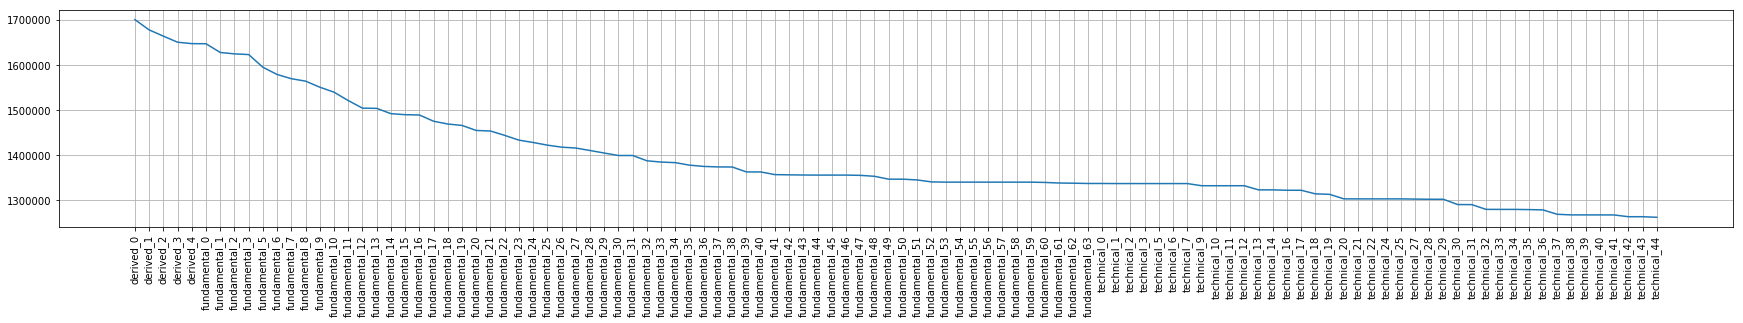

In [4]:
selected=data.id>-10000
features=[]
data_size=[]
for feature in data_clips:
    selected = selected & (((data[feature]<data_clips[feature]) & (data[feature]>-data_clips[feature])) | 
                           (data[feature].isnull()))
    features.append(feature)
    data_size.append(data[selected].shape[0])
    #print (feature, ': ', data[selected].shape)

x=range(len(features))
plt.figure(figsize=(30,4))
plt.xticks(x, features, rotation='vertical', fontsize=10)
plt.plot(x, data_size)
plt.grid()
plt.show()

In [5]:
data_cleaned=data[selected].copy()

In [6]:
selected2=['technical_20','technical_30','fundamental_11','technical_19','technical_24','id','y']
data_cleaned=data_cleaned[selected2]

In [7]:
_mean = data_cleaned.median(axis=0)
data_cleaned.fillna(_mean ,inplace=True);

In [8]:
train, test = train_test_split(data_cleaned, test_size=0.25, random_state=8, shuffle= False)
Y_train = train.y
X_train = train.drop(['y','id'], axis=1)
Y_test = test.y
X_test = test.drop(['y','id'], axis=1)

In [9]:
def r_score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return (np.sign(r2)*np.sqrt(np.abs(r2)))

In [10]:
epochs=500
batch_size=1024
feature_size=X_train.shape[1]
test_size=X_test.shape[0]

In [11]:
x = tf.placeholder("float", [batch_size, feature_size])
y = tf.placeholder("float", [batch_size])
x_test = tf.constant(X_test)
weights = {
    'h1': tf.get_variable("h1", shape=[feature_size, 512],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h2': tf.get_variable("h2", shape=[512, 1024],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h3': tf.get_variable("h3", shape=[1024, 1024],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h4': tf.get_variable("h4", shape=[1024, 512],
           initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable("out", shape=[512, 1],
           initializer=tf.contrib.layers.xavier_initializer()),
}
weights1 = {
    'h1': tf.Variable(tf.truncated_normal([feature_size, 512],mean=0.0001, stddev=0.00001)),
    'h2': tf.Variable(tf.truncated_normal([512, 1024],mean=0.0001, stddev=0.00001)),
    'h3': tf.Variable(tf.truncated_normal([1024, 1024],mean=0.0001, stddev=0.00001)),
    'h4': tf.Variable(tf.truncated_normal([1024, 512],mean=0.0001, stddev=0.00001)),
    'out': tf.Variable(tf.truncated_normal([512, 1],mean=0.0001, stddev=0.00001)),
}

biases = {
    'b1': tf.Variable(tf.random_normal([512], 0, 0.1)),
    'b2': tf.Variable(tf.random_normal([1024], 0, 0.1)),
    'b3': tf.Variable(tf.random_normal([1024], 0, 0.1)),
    'b4': tf.Variable(tf.random_normal([512], 0, 0.1)),
    'out': tf.Variable(tf.random_normal([1], 0, 0.1))
}

In [12]:
def deep_net(x, weights, biases,keep_prob=0.5):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)

    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_3 = tf.nn.dropout(layer_3, keep_prob)

    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
    layer_4 = tf.nn.dropout(layer_4, keep_prob)

    # Output layer with linear activation
    out_layer = tf.add(tf.matmul(layer_4, weights['out']), biases['out'])
    return out_layer

In [13]:
pred =   tf.transpose(deep_net(x, weights1, biases))
pred_test= deep_net(x_test, weights1, biases)
sub=pred-y
sq=tf.square(pred-y)
top=tf.nn.top_k(pred,k=1)
top_pred=pred[0,top.indices[0,0]]
top_y=x[top.indices[0,0]]
cost = tf.reduce_mean(tf.square(pred-y))
optimizer = tf.train.FtrlOptimizer(learning_rate=0.001, 
                                   l2_regularization_strength=0.5).minimize(cost)

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    random.seed(0)
    for epoch in range(epochs):
        selected=random.sample(list(X_train.index), batch_size)
        x_batch=X_train.loc[selected]
        y_batch=Y_train.loc[selected]
        _, c, pred_test_ = sess.run([optimizer, cost, pred_test], feed_dict={
                x: x_batch, y: y_batch})
        print (epoch, ' : ', c)
        print ('r_score : ', r_score(Y_test, pred_test_))


0  :  0.00180289
r_score :  -1.57874632544
1  :  0.000313642
r_score :  -0.01937836723
2  :  0.000328124
r_score :  -0.0191795179017
3  :  0.000347916
r_score :  -0.0189163837444
4  :  0.000305434
r_score :  -0.0188146463568
5  :  0.000337178
r_score :  -0.0185437191963
6  :  0.000361233
r_score :  -0.0184368515788
7  :  0.000343347
r_score :  -0.0185144254126
8  :  0.000317288
r_score :  -0.0183941928178
9  :  0.000310526
r_score :  -0.0181236775411
10  :  0.000302044
r_score :  -0.0181294485399
11  :  0.000305678
r_score :  -0.0180020642531
12  :  0.000302842
r_score :  -0.0177745820696
13  :  0.000341758
r_score :  -0.0178265732504
14  :  0.000305036
r_score :  -0.0177140496347
15  :  0.000334109
r_score :  -0.0176798550116
16  :  0.000313553
r_score :  -0.0176280772518
17  :  0.000330965
r_score :  -0.017415001233
18  :  0.000331675
r_score :  -0.0173689356271
19  :  0.000350786
r_score :  -0.0172739414552
20  :  0.000357586
r_score :  -0.0169801445425
21  :  0.000297868
r_score : 

172  :  0.000320731
r_score :  -0.0040672195123
173  :  0.000295053
r_score :  -0.00411715824531
174  :  0.000292603
r_score :  -0.00414561855271
175  :  0.000334818
r_score :  -0.00388647436807
176  :  0.000305912
r_score :  -0.00377080539103
177  :  0.000310263
r_score :  -0.00380703238458
178  :  0.000312772
r_score :  -0.00370346423523
179  :  0.000296866
r_score :  -0.0034776943953
180  :  0.000276437
r_score :  -0.00355618378947
181  :  0.000318077
r_score :  -0.0032648779597
182  :  0.000317187
r_score :  -0.00313937075337
183  :  0.000355144
r_score :  -0.00319240801088
184  :  0.000318882
r_score :  -0.00325010339721
185  :  0.00038208
r_score :  -0.00318616240918
186  :  0.00034872
r_score :  -0.00334077487553
187  :  0.000339036
r_score :  -0.00340392876378
188  :  0.000338723
r_score :  -0.00355471403028
189  :  0.000294428
r_score :  -0.0032195792142
190  :  0.000335108
r_score :  -0.00288249987943
191  :  0.000326921
r_score :  -0.00306258743449
192  :  0.000303693
r_scor

339  :  0.000307352
r_score :  -0.00108264385957
340  :  0.000274912
r_score :  -0.00115038367221
341  :  0.000302185
r_score :  -0.00120820407019
342  :  0.000297073
r_score :  -0.00136730080144
343  :  0.000314887
r_score :  -0.00142598996733
344  :  0.000305353
r_score :  -0.00140121922034
345  :  0.000264714
r_score :  -0.00144015525452
346  :  0.000288634
r_score :  -0.00136114666713
347  :  0.000342947
r_score :  -0.00141364302667
348  :  0.000321513
r_score :  -0.00133690880031
349  :  0.000290923
r_score :  -0.00135321306725
350  :  0.000311336
r_score :  -0.00152344198293
351  :  0.000329014
r_score :  -0.0016153980888
352  :  0.000306947
r_score :  -0.00169307899204
353  :  0.000282804
r_score :  -0.00175790729932
354  :  0.000353584
r_score :  -0.00164747772523
355  :  0.000335122
r_score :  -0.00179193738315
356  :  0.000302405
r_score :  -0.0016021765379
357  :  0.000310008
r_score :  -0.00186330054584
358  :  0.000275684
r_score :  -0.00178828193027
359  :  0.000296813
r_